In [1]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn; import os; import math
from sklearn import feature_selection, linear_model, grid_search, cross_validation, metrics, ensemble, learning_curve 
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from datetime import datetime
from sklearn.cluster import KMeans
import pickle
import seaborn as sns
import xgboost as xgb
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [25]:
#Отбираем ПОСЛЕДНИЕ залоговые билеты со статусом Новый залог за последний год
sql_query = "SELECT  \
      [PartnerID] \
      ,[Age] \
      ,[SEX] \
      ,[CityID] \
      ,LifeTimeM*30/QntPurchaseCode AvgDneyPrihodov \
      ,[LifeTimeM] + DATEDIFF(Month, PurchaseDateTime, GetDate()) [LifeTimeM] \
      ,[QntPurchaseCode] \
      ,[SumQuantity] \
      ,[SUMisPartnerPromotionID] \
      ,[PercentisPartnerPromotionID] \
      ,[AVGisPartnerPromotionID] \
      ,[SUMisCrossPromo] \
      ,[PercentisCrossPromo] \
      ,[AVGisCrossPromo] \
      ,[PercentSMS_new] \
      ,[AVGPercentinSMS] \
      ,[PercentMonth1] \
      ,[PercentMonth2] \
      ,[PercentMonth3] \
      ,[PercentMonth4] \
      ,[PercentMonth5] \
      ,[PercentMonth6] \
      ,[PercentMonth7] \
      ,[PercentMonth8] \
      ,[PercentMonth9] \
      ,[PercentMonth10] \
      ,[PercentMonth11] \
      ,[PercentMonth12] \
      ,[PercentNY] \
      ,[PercentDR] \
      ,[PercentVD] \
      ,[Percent8M] \
      ,[SUMPrice] \
      ,[AVGPrice] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SumSummaDiscount] \
      ,[AvgSummaDiscount] \
      ,[AVGProcentSkidki] \
      ,[PercentMen] \
      ,[SumChild] \
      ,[PercentChild] \
      ,[PercentKolco] \
      ,[PercentSERGI] \
      ,[PercentPODVES] \
      ,[PercentFUTLAR] \
      ,[PercentCEP] \
      ,[PercentBRASLET] \
      ,[PercentKOLE] \
      ,[PercentNKNOWN_WEAR] \
      ,[AVGCostPrice] \
      ,[AVGCostMin] \
      ,[AVGCostTag] \
      ,[AVGCostStock] \
      ,[AVGCostRetail] \
      ,[AVGGiftCardPositionID] \
      ,[SumGiftCardPositionID] \
      ,[AVGQntName] \
      ,[PercentExpensive] \
      ,[PercentCheap] \
      ,[PercentPremium] \
      ,[PercentMidle] \
      ,[PercentGold] \
      ,[PercentSilver] \
      ,[PercentNoMetal] \
  FROM [Gold585].[dbo].[RetailCommon] a \
  WHERE partnerID <> 0 and PurchaseDateTime = (Select MAX(PurchaseDateTime) MaxDate From RetailCommon rt where rt.PartnerID = a.PartnerID) \
  and PurchaseDateTime >= CAST('2015-01-01' as DATE) \
  order BY PartnerID, PurchaseDateTime"
data = pd.read_sql(sql_query,conn)

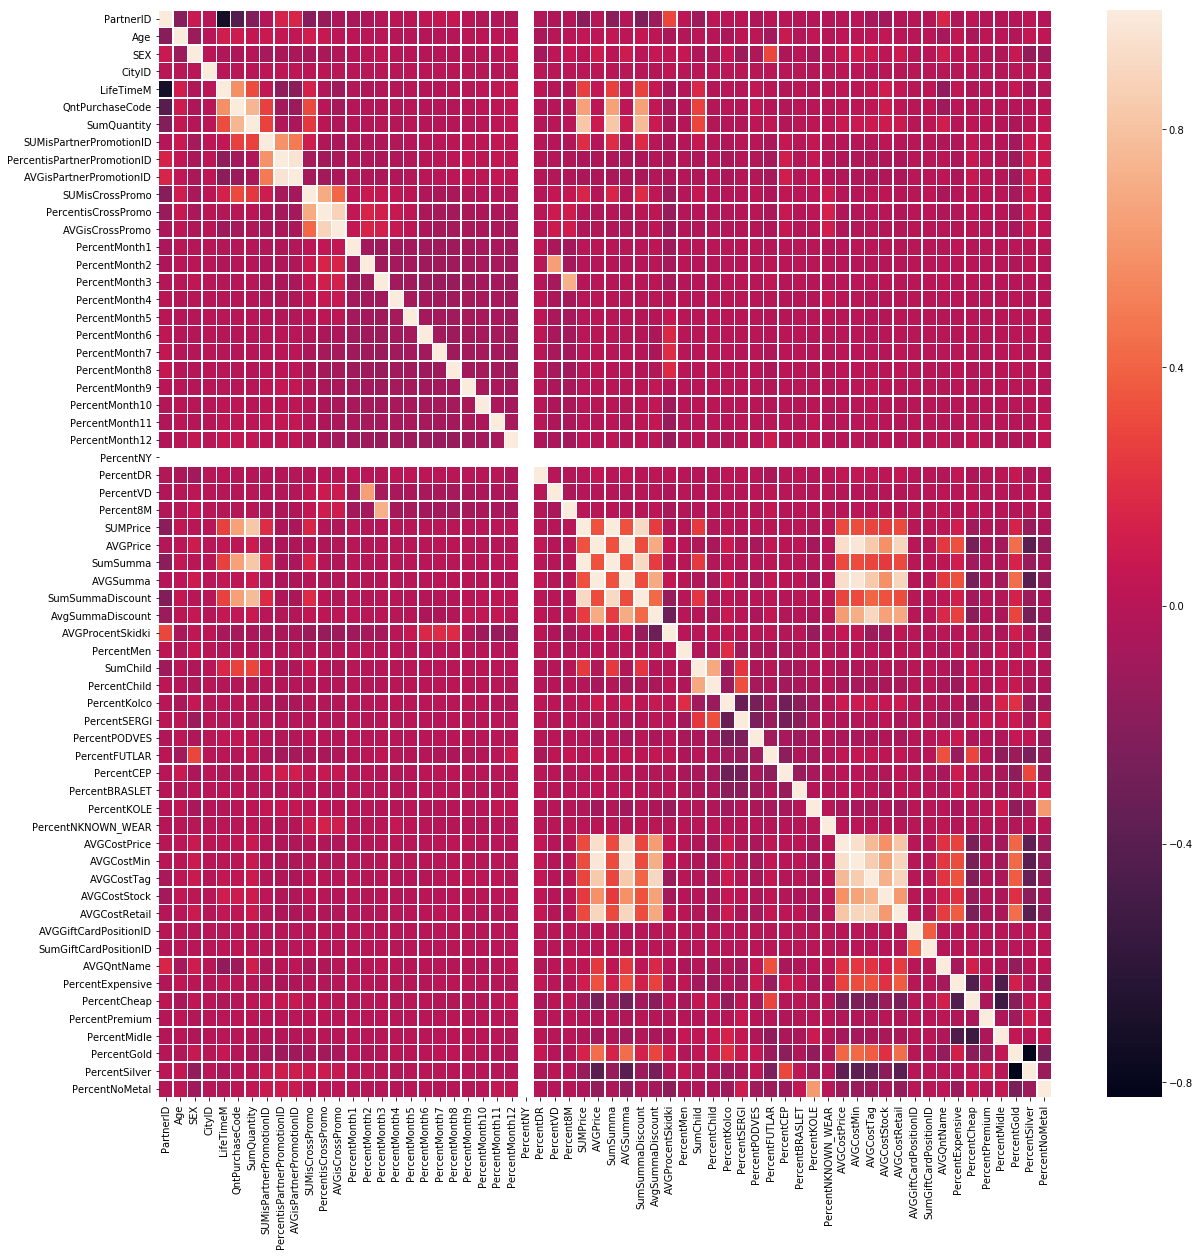

In [3]:
cormatrx=data.corr()
cormatrx
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(cormatrx,  linewidths=.5, ax=ax)

In [12]:
cormatrx.to_csv('corrmtx.csv')

In [3]:
data.shape

(2521448, 63)

In [4]:
data[data['QntPurchaseCode']>1].shape

(957262, 63)

In [5]:
data.head()

,PartnerID,Age,SEX,CityID,AvgDneyPrihodov,LifeTimeM,QntPurchaseCode,SumQuantity,SUMisPartnerPromotionID,PercentisPartnerPromotionID,...,AVGGiftCardPositionID,SumGiftCardPositionID,AVGQntName,PercentExpensive,PercentCheap,PercentPremium,PercentMidle,PercentGold,PercentSilver,PercentNoMetal
0,2,46,0,35,0,32,1,2.0,0,0,...,0,0,1,0.00,0.0,0.0,1.00,1.0,0.000000,0.0
1,4,118,0,92,75,21,8,12.0,0,0,...,0,0,1,0.25,0.5,0.0,0.25,0.0,0.916667,0.0
2,6,30,0,32,0,32,1,2.0,0,0,...,0,0,2,0.00,0.0,0.0,1.00,1.0,0.000000,0.0
3,9,116,0,122,0,32,1,1.0,0,0,...,0,0,1,1.00,0.0,0.0,0.00,1.0,0.000000,0.0
4,10,20,0,105,0,32,1,2.0,0,0,...,0,0,2,0.00,1.0,0.0,0.00,0.0,0.500000,0.5


In [5]:
#data['AvgDneyPrihodov'] = data['LifeTimeM']*30/data['QntPurchaseCode']

In [6]:
data[data['PartnerID']==3831021]

,PartnerID,Age,SEX,CityID,AvgDneyPrihodov,LifeTimeM,QntPurchaseCode,SumQuantity,SUMisPartnerPromotionID,PercentisPartnerPromotionID,...,AVGGiftCardPositionID,SumGiftCardPositionID,AVGQntName,PercentExpensive,PercentCheap,PercentPremium,PercentMidle,PercentGold,PercentSilver,PercentNoMetal
1358052,3831021,59,0,84,70,21,3,3.0,0,0,...,0,0,1,0.333333,0.666667,0.0,0.0,1.0,0.0,0.0


In [7]:
print(np.percentile(data['SumSumma'],99)) # 

80172.0


In [8]:
data[data['SumSumma']>84387.95999999996].PartnerID.count()

22658

In [9]:
print(np.percentile(data['QntPurchaseCode'],99)) #- вывод - у 99 процентов посетителей < 10 покупок

10.0


In [14]:
data[data['QntPurchaseCode']>10].PartnerID.count()

20953

In [12]:
data.shape

(2521448, 63)

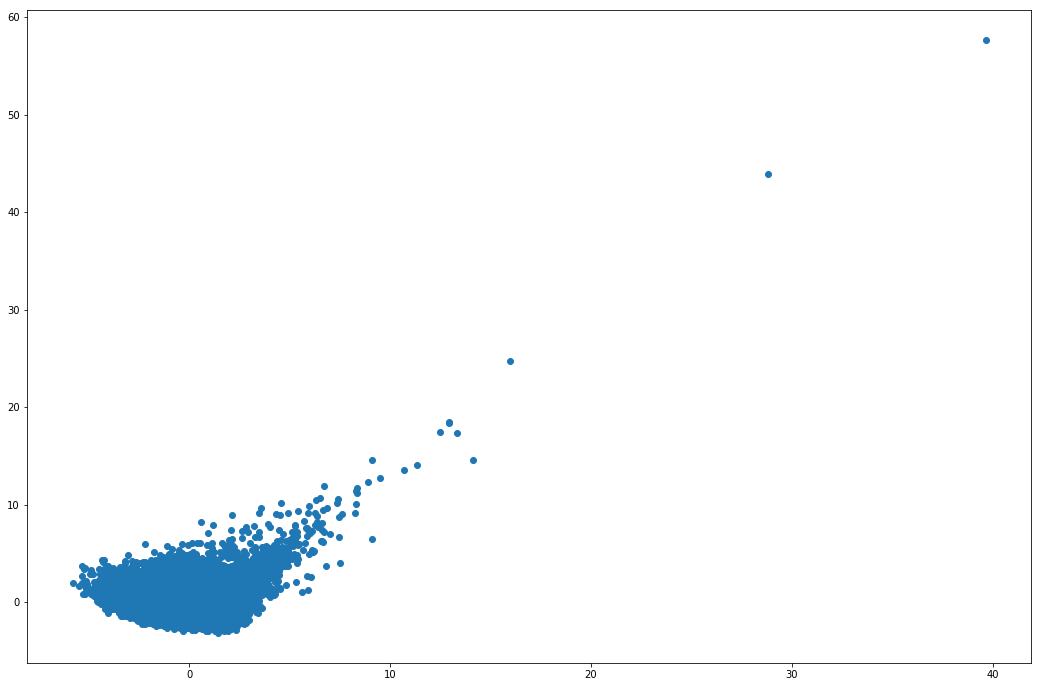

In [11]:
# посмотрим отдельно на этот 1 процент
df_2 = data[data['QntPurchaseCode']>=10].fillna(0)
df_2.reset_index(drop=True,inplace = True)
target_2=df_2.drop(['PartnerID','CityID','SUMisPartnerPromotionID','SumQuantity','SUMisPartnerPromotionID','AVGisPartnerPromotionID','SUMisCrossPromo','AVGisCrossPromo' \
                ,'PercentVD', 'Percent8M', 'PercentDR','PercentNY' ,'AVGPrice', 'PercentMen', 'PercentChild'\
                ,'PercentFUTLAR','PercentKOLE', 'PercentExpensive', 'PercentCheap', 'PercentPremium', 'PercentMidle' \
               ,'PercentMonth1','PercentMonth2','PercentMonth3','PercentMonth4','PercentMonth5','PercentMonth6' \
               ,'PercentMonth7','PercentMonth8','PercentMonth9','PercentMonth10','PercentMonth11','PercentMonth12', 'AVGCostPrice' \
                ,'PercentNKNOWN_WEAR','AVGQntName','AVGGiftCardPositionID','PercentNoMetal' \
               ,'SUMPrice','SumSummaDiscount','AvgSummaDiscount','SumChild','AVGCostMin','AVGCostTag','AVGCostStock','AVGCostRetail','SumGiftCardPositionID'], axis=1)
#target_2 = pd.get_dummies(target_2, columns = ['CityID'])
X_2 = StandardScaler().fit_transform(target_2)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X_2)
targert_2 = pca.transform(X_2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert_2[:, 0], targert_2[:, 1])

In [15]:
target_2.columns.values

array(['Age', 'SEX', 'AvgDneyPrihodov', 'LifeTimeM', 'QntPurchaseCode',
       'PercentisPartnerPromotionID', 'PercentisCrossPromo', 'SumSumma',
       'AVGSumma', 'AVGProcentSkidki', 'PercentKolco', 'PercentSERGI',
       'PercentPODVES', 'PercentCEP', 'PercentBRASLET', 'PercentGold',
       'PercentSilver'], dtype=object)

In [16]:
df_2.shape

(27063, 63)

Wall time: 6.46 s


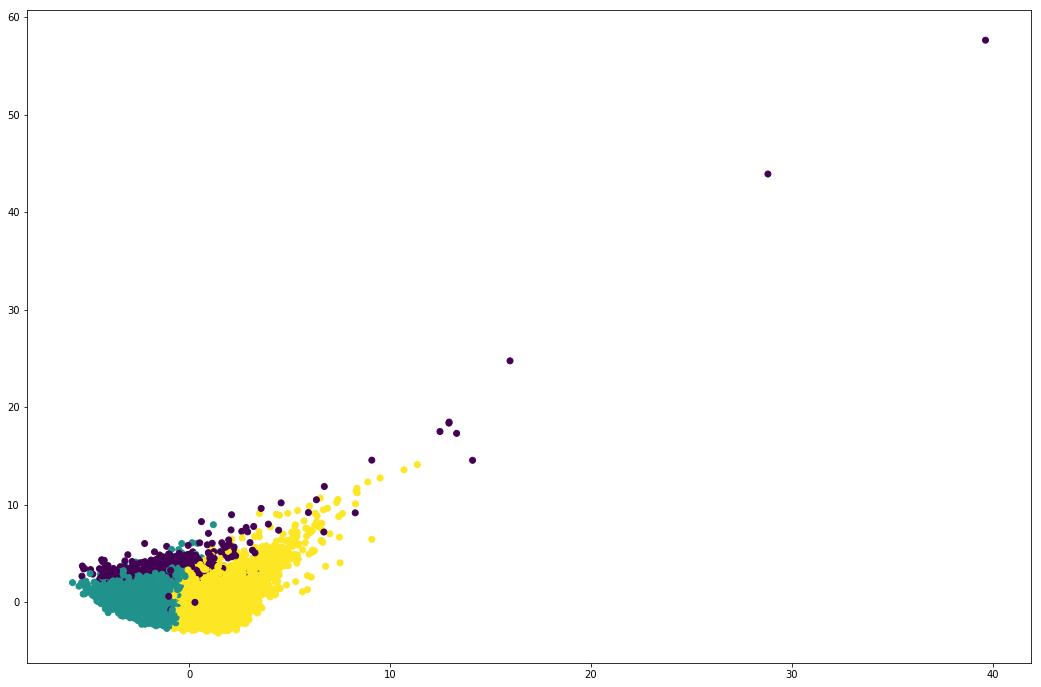

In [19]:
%%time
# Покупатели с больше (или равно) чем 10 чеками
kmeans = KMeans(n_clusters= 3, random_state=1,n_jobs=-1).fit(X_2)
labels = kmeans.predict(X_2)
df_2['labels']=pd.DataFrame(labels)

targert_2 = pd.DataFrame(targert_2,columns=('X','Y'))
targert_2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert_2['X'], targert_2['Y'],c =labels)

In [22]:
print(df_2.shape[0])
print(df_2[df_2['labels']==0].shape[0],df_2[df_2['labels']==0].shape[0]/df_2.shape[0])
print(df_2[df_2['labels']==1].shape[0],df_2[df_2['labels']==1].shape[0]/df_2.shape[0])
print(df_2[df_2['labels']==2].shape[0],df_2[df_2['labels']==2].shape[0]/df_2.shape[0])

27063
775 0.0286368843069874
9062 0.3348483168902191
17226 0.6365147988027935


In [24]:
pd.concat([df_2[df_2[df_2['labels']==0].describe().T['mean'], \
           df_2[df_2[df_2['labels']==1].describe().T['mean'], \
           df_2[df_2[df_2['labels']==2].describe().T['mean'], \
           ],axis=1).to_csv('3-cl.csv')

SyntaxError: invalid syntax (<ipython-input-24-0e904e5bd08c>, line 1)

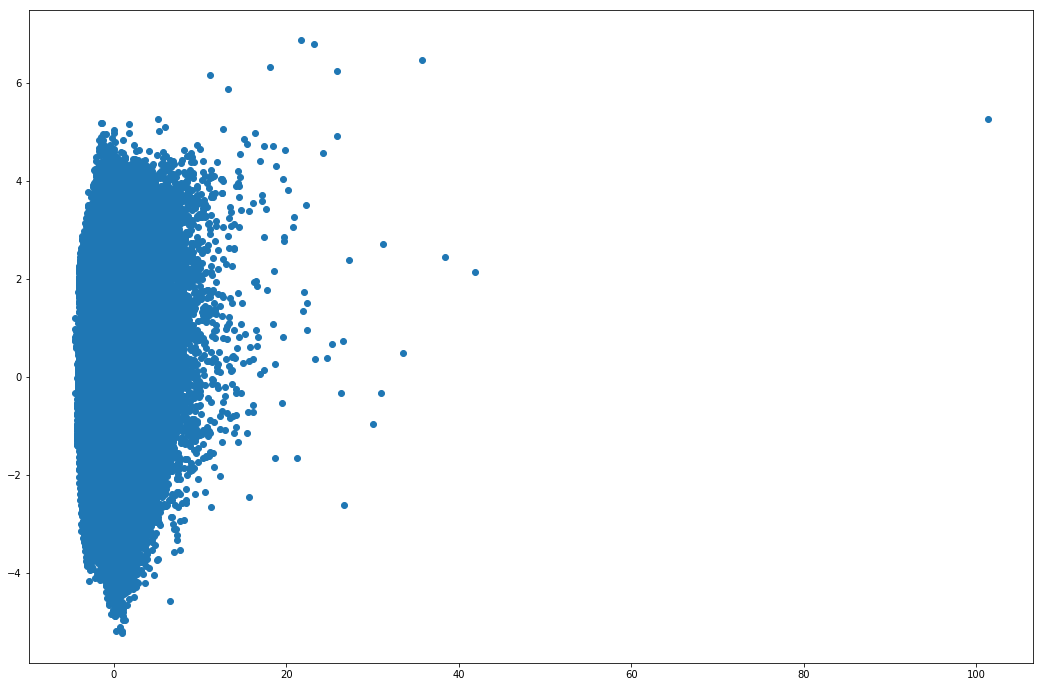

In [119]:
df = data[((data['QntPurchaseCode']<=10) & (data['QntPurchaseCode']>1))].fillna(0)
df.reset_index(drop=True,inplace = True)
target=df.drop(['PartnerID','CityID','SUMisPartnerPromotionID','SumQuantity','SUMisPartnerPromotionID','AVGisPartnerPromotionID','SUMisCrossPromo','AVGisCrossPromo' \
                ,'PercentVD', 'Percent8M', 'PercentDR','PercentNY' ,'AVGPrice', 'PercentMen', 'PercentChild'\
                ,'PercentFUTLAR','PercentKOLE', 'PercentExpensive', 'PercentCheap', 'PercentPremium', 'PercentMidle' \
               ,'PercentMonth1','PercentMonth2','PercentMonth3','PercentMonth4','PercentMonth5','PercentMonth6' \
               ,'PercentMonth7','PercentMonth8','PercentMonth9','PercentMonth10','PercentMonth11','PercentMonth12', 'AVGCostPrice' \
                ,'PercentNKNOWN_WEAR','AVGQntName','AVGGiftCardPositionID','PercentNoMetal' \
               ,'SUMPrice','SumSummaDiscount','AvgSummaDiscount','SumChild','AVGCostMin','AVGCostTag','AVGCostStock','AVGCostRetail','SumGiftCardPositionID'], axis=1)
#target = pd.get_dummies(target, columns = ['CityID'])
X = StandardScaler().fit_transform(target)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

In [18]:
target.columns.values

NameError: name 'target' is not defined

In [120]:
df.shape

(936309, 63)

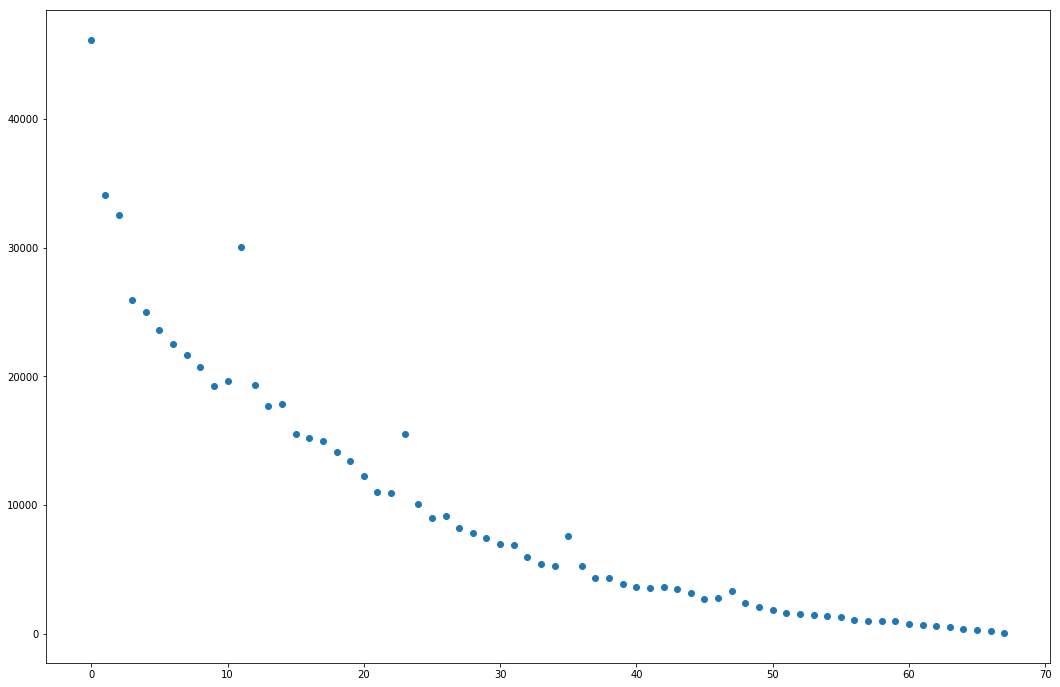

In [33]:
a = data.groupby('LifeTimeM')[['QntPurchaseCode']].count()
plt.scatter(np.arange(len(a)-1),a[1:])

           QntPurchaseCode
LifeTimeM                 
0                   969920  - людей с 1 покупкой (с января 2017)


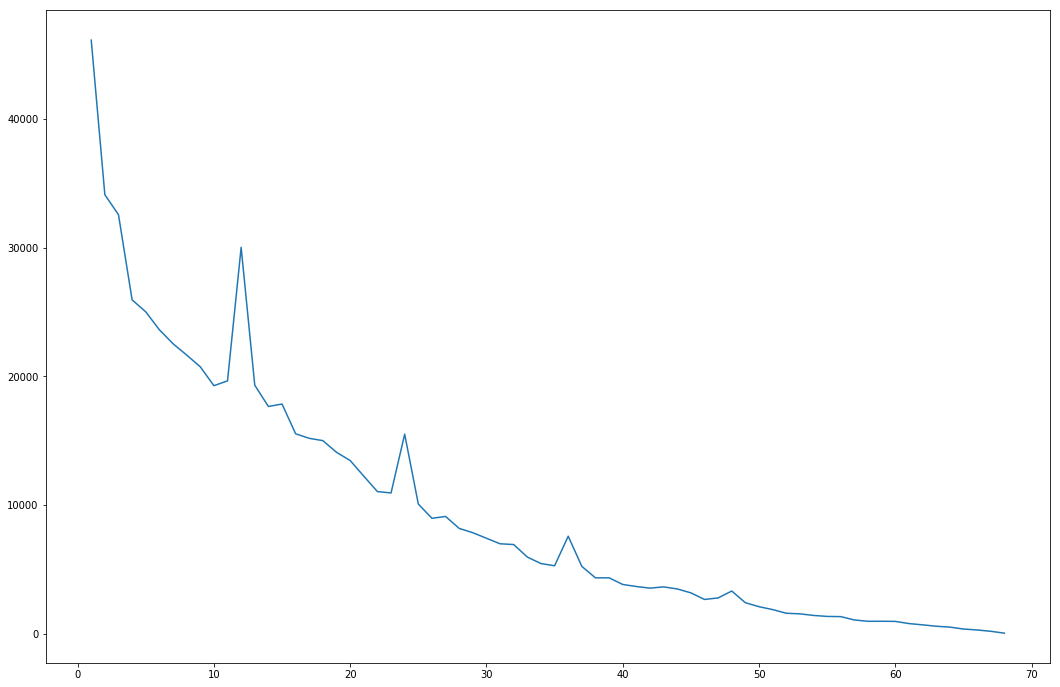

In [34]:
print(a[0:1], " - людей с 1 покупкой (с января 2017)")
plt.plot(a[1:])

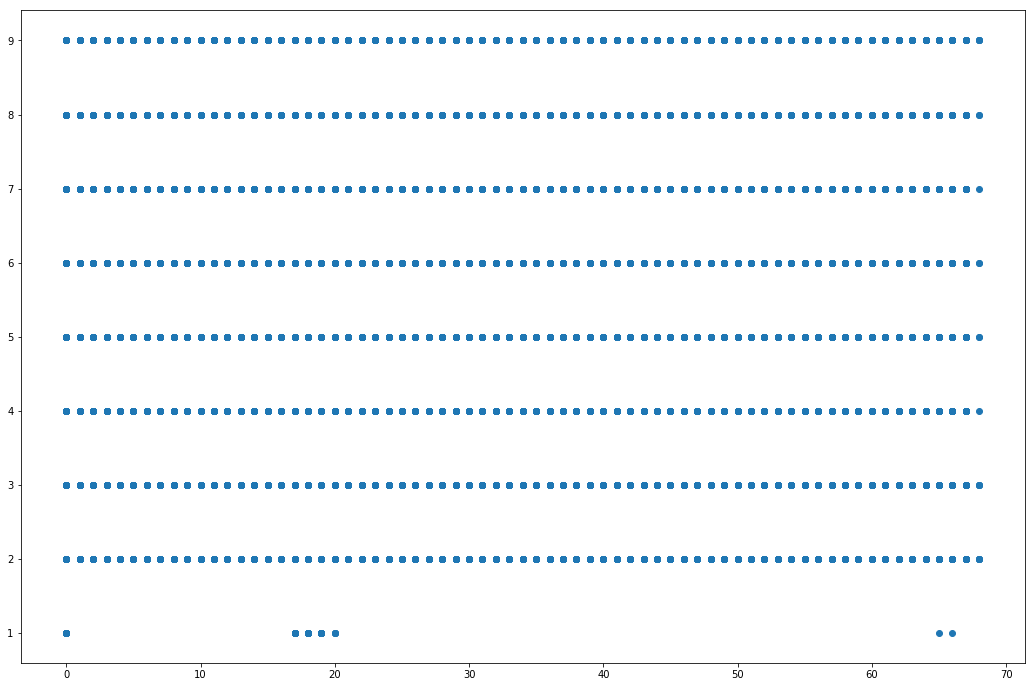

In [89]:
plt.scatter(df['LifeTimeM'], df['QntPurchaseCode']);

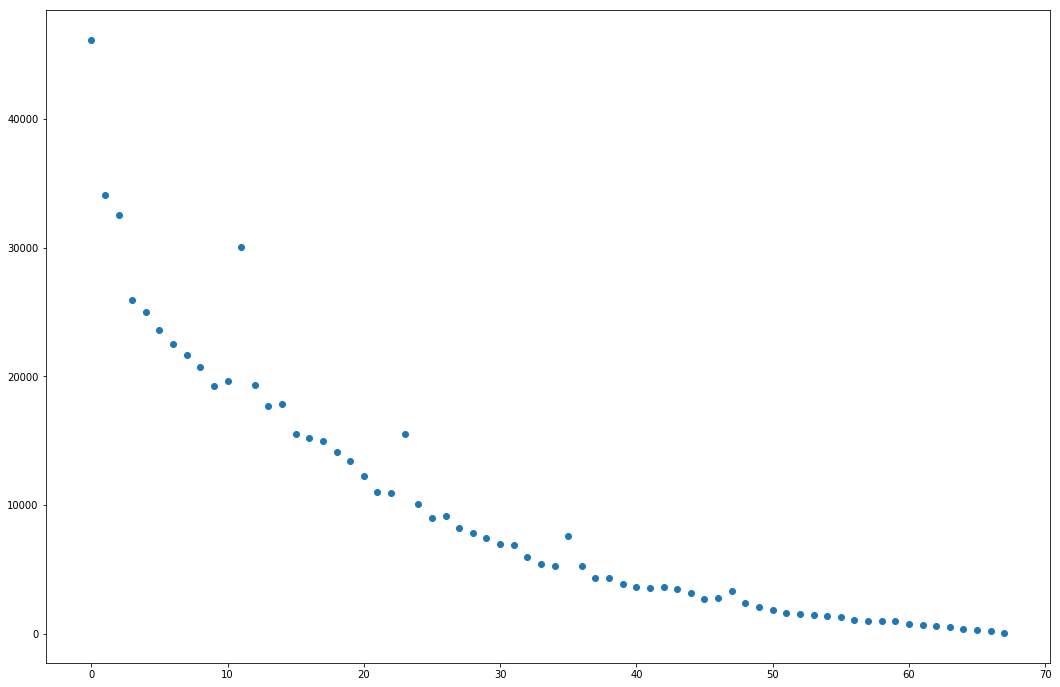

In [83]:
b = data.groupby('LifeTimeM')[['QntPurchaseCode']].count()
plt.scatter(np.arange(len(b)-1),b[1:])

Количество клиентов от количества чеков


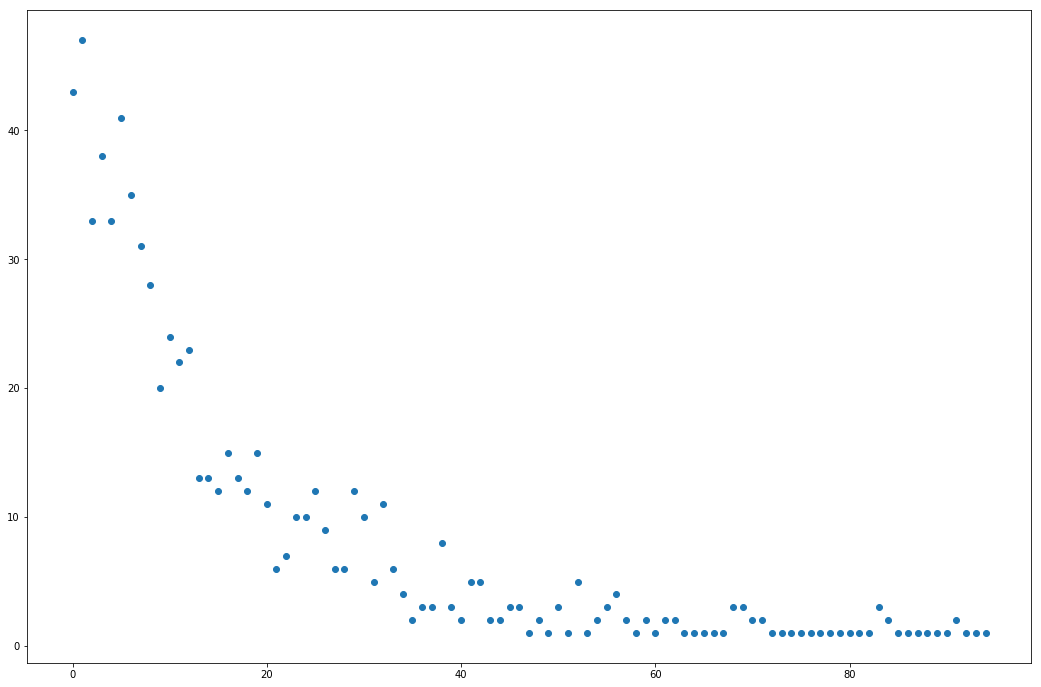

In [90]:
b = data.groupby('QntPurchaseCode')[['PartnerID']].count()
print('Количество клиентов от количества чеков')
plt.scatter(np.arange(len(b)-35),b[35:]);

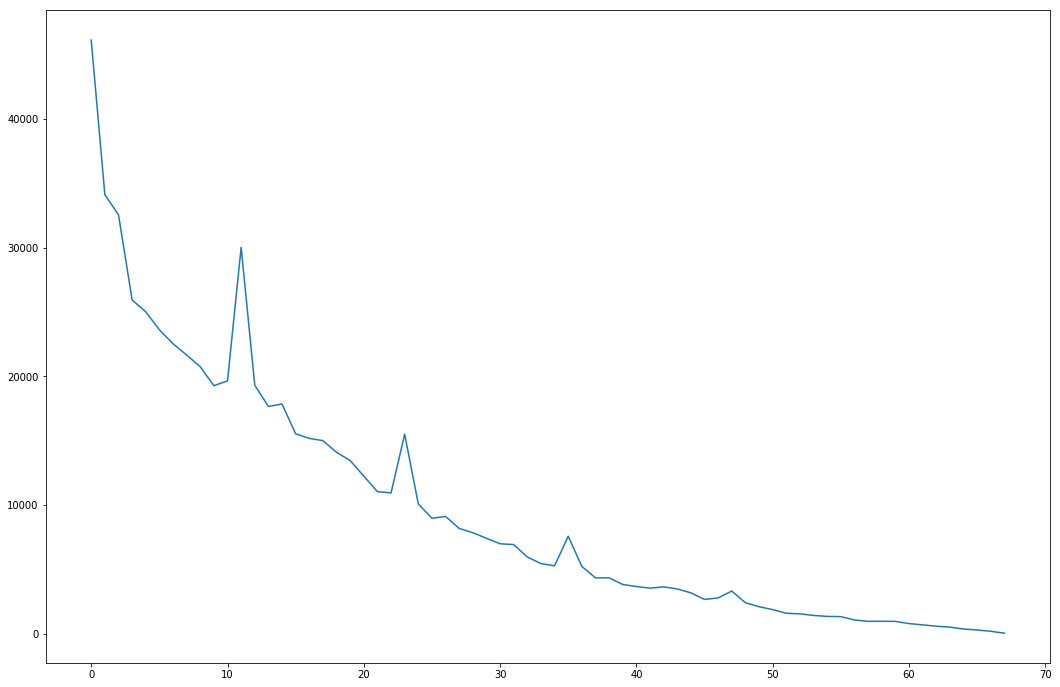

In [82]:
b = data.groupby('LifeTimeM')[['PartnerID']].count()
#print('Количество клиентов от количества чеков')
plt.plot(np.arange(len(b)-1),b[1:]);

Количество клиентов от количества чеков


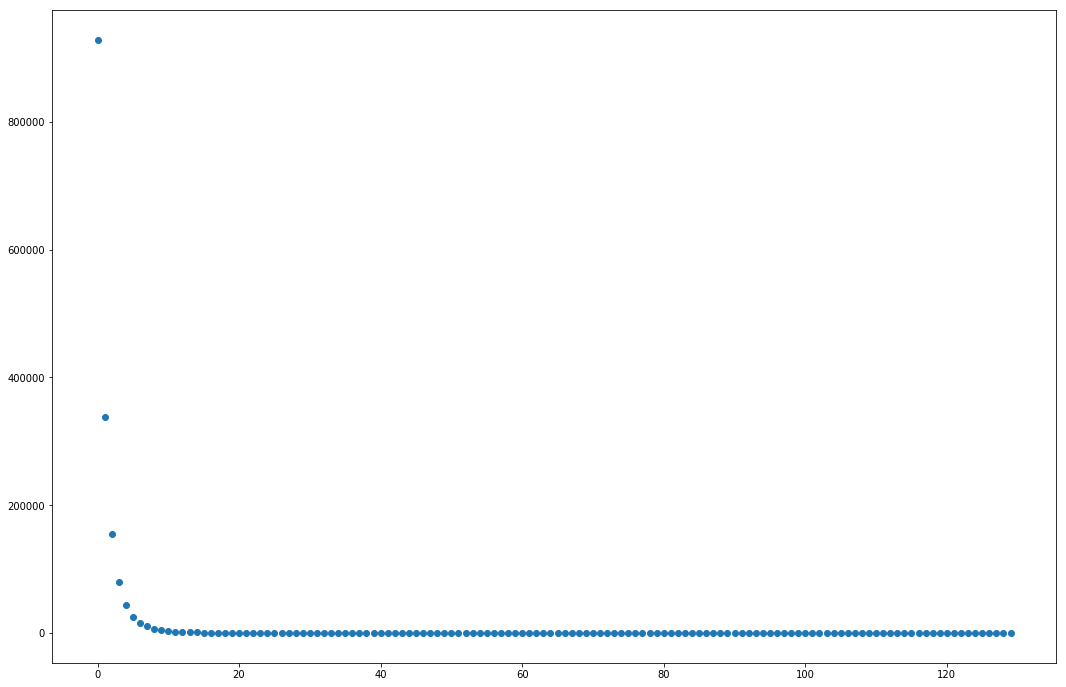

In [77]:
b = data.groupby('QntPurchaseCode')[['PartnerID']].count()
print('Количество клиентов от количества чеков')
plt.scatter(np.arange(len(b)),b[:]);

In [69]:
b = data.groupby('SumSumma')[['PartnerID']].count()

In [71]:
b.tail()

,PartnerID
SumSumma,
5138520.85,1
5431268.00,1
7899699.00,1
13860032.80,1
20950841.40,1


In [91]:
print(datetime.datetime.now())

2018-09-12 18:11:25.852297


In [36]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils import check_X_y
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster.unsupervised import check_number_of_labels

def silhouette_samples_memory_saving(X, labels, metric='euclidean', **kwds):
    X, labels = check_X_y(X, labels, accept_sparse=['csc', 'csr'])
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    check_number_of_labels(len(le.classes_), X.shape[0])

    unique_labels = le.classes_
    n_samples_per_label = np.bincount(labels, minlength=len(unique_labels))

    # For sample i, store the mean distance of the cluster to which
    # it belongs in intra_clust_dists[i]
    intra_clust_dists = np.zeros(X.shape[0], dtype=X.dtype)

    # For sample i, store the mean distance of the second closest
    # cluster in inter_clust_dists[i]
    inter_clust_dists = np.inf + intra_clust_dists

    for curr_label in range(len(unique_labels)):

        # Find inter_clust_dist for all samples belonging to the same
        # label.
        mask = labels == curr_label

        # Leave out current sample.
        n_samples_curr_lab = n_samples_per_label[curr_label] - 1
        if n_samples_curr_lab != 0:
            intra_distances = pairwise_distances(X[mask, :], metric=metric, **kwds)
            intra_clust_dists[mask] = np.sum(intra_distances, axis=1) / n_samples_curr_lab

        # Now iterate over all other labels, finding the mean
        # cluster distance that is closest to every sample.
        for other_label in range(len(unique_labels)):
            if other_label != curr_label:
                other_mask = labels == other_label
                inter_distances = pairwise_distances(X[mask, :], X[other_mask, :], metric=metric, **kwds)
                other_distances = np.mean(inter_distances, axis=1)
                inter_clust_dists[mask] = np.minimum(inter_clust_dists[mask], other_distances)

    sil_samples = inter_clust_dists - intra_clust_dists
    sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
    # score 0 for clusters of size 1, according to the paper
    sil_samples[n_samples_per_label.take(labels) == 1] = 0

    return np.mean(sil_samples)

2018-09-13 11:39:42.799080
0.14755411413296518
0.1549878425097895
0.1323397910498276
0.12913236628075614
0.12437354048003631
0.12483701567340519
0.1281405442328858
0.13213592178739791
0.136842457816671


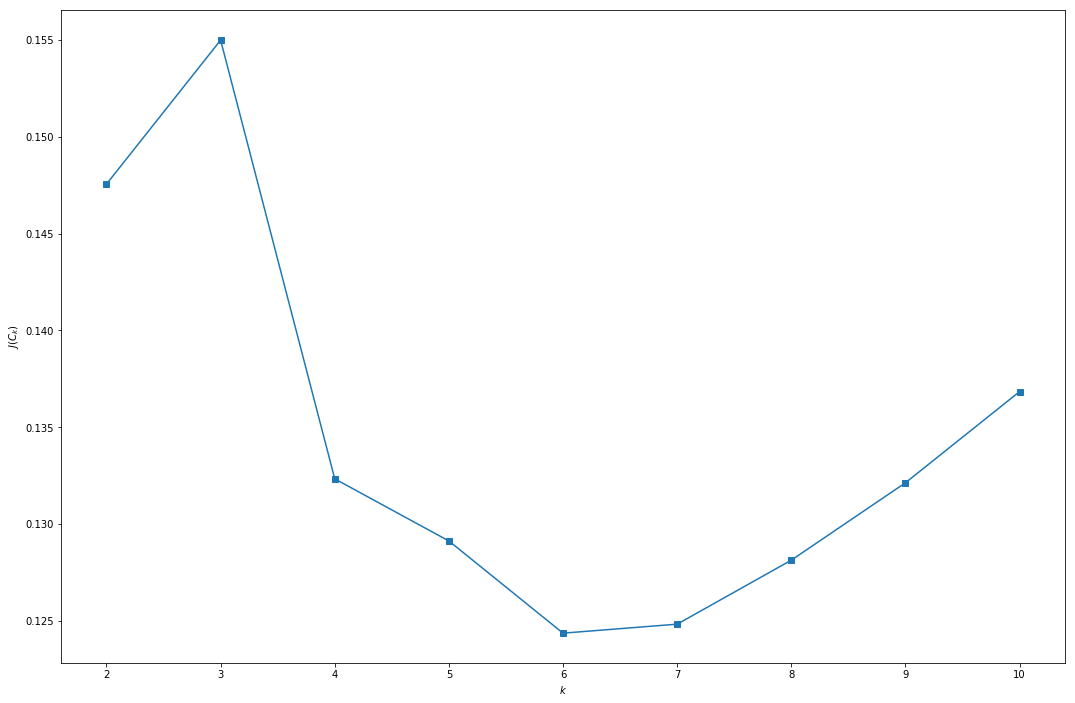

In [49]:
# 1% у кого больше 10 покупок
now = datetime.datetime.now()
print(now)
X1 = pd.DataFrame(X_2) #.sample(50000)

# с процентами новых и ОСН
from sklearn.metrics import silhouette_score
mas = []
mas1 = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X1)
    labels = kmeans.predict(X1)
    #a1= silhouette_samples_memory_saving(X1, kmeans.labels_)
    a= silhouette_score(X1, kmeans.labels_)
    mas.append(a)
    mas1.append(a1)
    print(a)

plt.plot(range(2, 11), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');


# Оптимальное количество кластеров, для 1 процента людей с самым большим числом покупок  - -возьмем 3 кластера

Wall time: 6.5 s


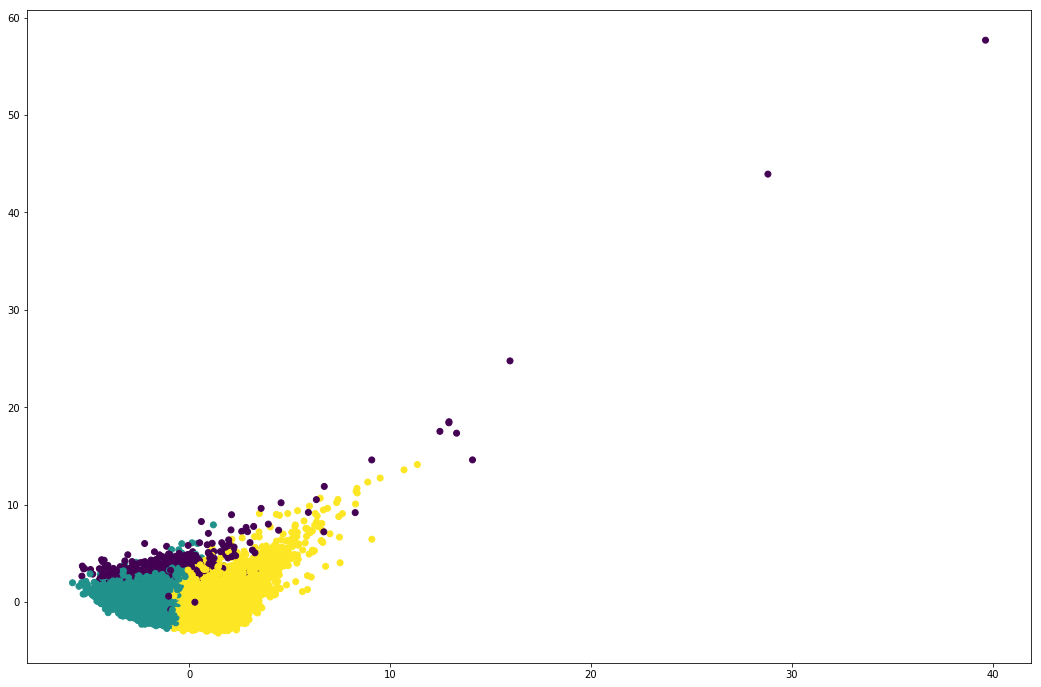

In [148]:
%%time
# Покупатели с больше чем 10 чеками
kmeans = KMeans(n_clusters= 3, random_state=1,n_jobs=-1).fit(X_2)
labels = kmeans.predict(X_2)
df_2['labels']=pd.DataFrame(labels)

targert_2 = pd.DataFrame(targert_2,columns=('X','Y'))
targert_2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert_2['X'], targert_2['Y'],c =labels)

Wall time: 31.2 s


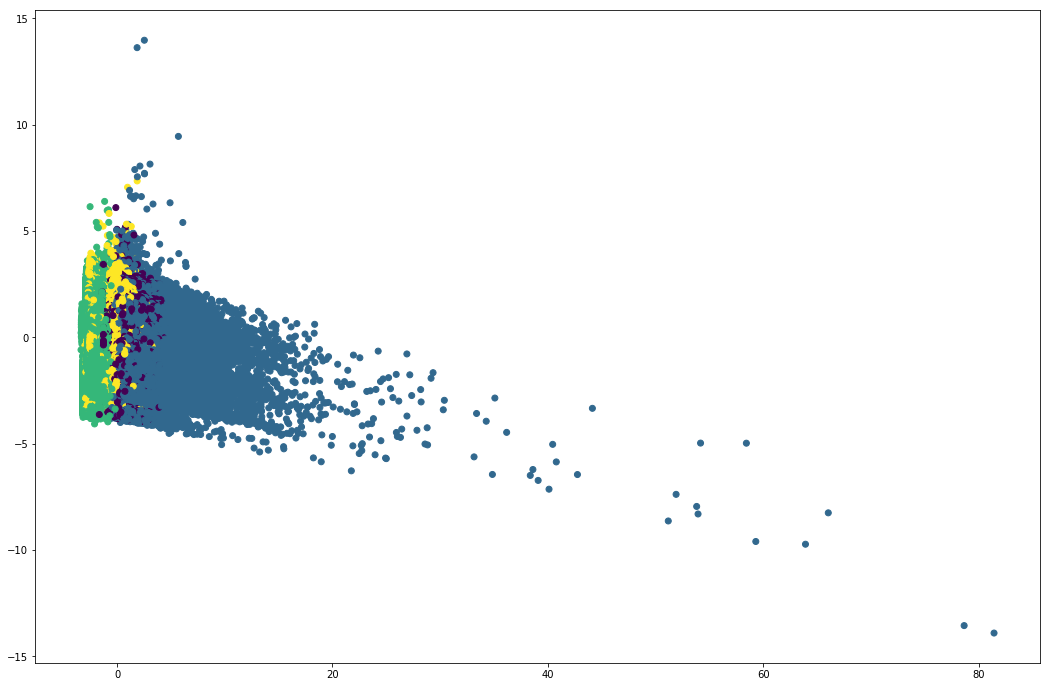

In [142]:
%%time
# Покупатели с 1 чеком
kmeans = KMeans(n_clusters= 4, random_state=1,n_jobs=-1).fit(X_2)
labels = kmeans.predict(X_2)
df_2['labels']=pd.DataFrame(labels)

targert_2 = pd.DataFrame(targert_2,columns=('X','Y'))
targert_2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert_2['X'], targert_2['Y'],c =labels)

In [143]:
df_2.head()

,PartnerID,Age,SEX,CityID,AvgDneyPrihodov,LifeTimeM,QntPurchaseCode,SumQuantity,SUMisPartnerPromotionID,PercentisPartnerPromotionID,...,SumGiftCardPositionID,AVGQntName,PercentExpensive,PercentCheap,PercentPremium,PercentMidle,PercentGold,PercentSilver,PercentNoMetal,labels
0,2,46,0,35,0,32,1,2.0,0,0,...,0,1,0.0,0.000000,0.0,1.000000,1.0,0.0,0.0,3
1,6,30,0,32,0,32,1,2.0,0,0,...,0,2,0.0,0.000000,0.0,1.000000,1.0,0.0,0.0,1
2,9,116,0,122,0,32,1,1.0,0,0,...,0,1,1.0,0.000000,0.0,0.000000,1.0,0.0,0.0,1
3,10,20,0,105,0,32,1,2.0,0,0,...,0,2,0.0,1.000000,0.0,0.000000,0.0,0.5,0.5,2
4,14,23,1,101,0,32,1,3.0,0,0,...,0,3,0.0,0.333333,0.0,0.666667,1.0,0.0,0.0,1


In [144]:
df_2.tail()

,PartnerID,Age,SEX,CityID,AvgDneyPrihodov,LifeTimeM,QntPurchaseCode,SumQuantity,SUMisPartnerPromotionID,PercentisPartnerPromotionID,...,SumGiftCardPositionID,AVGQntName,PercentExpensive,PercentCheap,PercentPremium,PercentMidle,PercentGold,PercentSilver,PercentNoMetal,labels
1564181,6522158,47,1,93,0,0,1,3.0,0,0,...,0,3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
1564182,6522161,22,1,92,0,0,1,2.0,0,0,...,0,2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
1564183,6522163,55,0,30,0,0,1,1.0,1,1,...,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2
1564184,6522164,19,0,92,0,0,1,2.0,1,1,...,0,2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
1564185,6522167,31,0,59,0,0,1,1.0,0,0,...,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0


In [146]:
print(df_2.shape[0])
print(df_2[df_2['labels']==0].shape[0])
print(df_2[df_2['labels']==1].shape[0])
print(df_2[df_2['labels']==2].shape[0])
print(df_2[df_2['labels']==3].shape[0])
#print(df[df['labels']==4].shape[0])
#print(df[df['labels']==5].shape[0])
#print(df[df['labels']==6].shape[0])

1564186
302596
612509
473693
175388


In [145]:
pd.concat([df_2[df_2['labels']==0].describe().T['50%'],df_2[df_2['labels']==0].describe().T['mean'],df_2[df_2['labels']==0].describe().T['std'], \
           df_2[df_2['labels']==1].describe().T['50%'],df_2[df_2['labels']==1].describe().T['mean'],df_2[df_2['labels']==1].describe().T['std'], \
           df_2[df_2['labels']==2].describe().T['50%'],df_2[df_2['labels']==2].describe().T['mean'],df_2[df_2['labels']==2].describe().T['std'], \
           df_2[df_2['labels']==3].describe().T['50%'],df_2[df_2['labels']==3].describe().T['mean'],df_2[df_2['labels']==3].describe().T['std'], \
 #          df[df['labels']==4].describe().T['50%'],df[df['labels']==4].describe().T['mean'],df[df['labels']==4].describe().T['std'], \
 #          df[df['labels']==5].describe().T['50%'],df[df['labels']==5].describe().T['mean'],df[df['labels']==5].describe().T['std'], \
 #          df[df['labels']==6].describe().T['50%'],df[df['labels']==6].describe().T['mean'],df[df['labels']==6].describe().T['std'], \
 #          df[df['labels']==7].describe().T['50%'],df[df['labels']==7].describe().T['mean'],df[df['labels']==7].describe().T['std'], \
 #          df[df['labels']==8].describe().T['50%'],df[df['labels']==8].describe().T['mean'],df[df['labels']==8].describe().T['std'], \
 #          df[df['labels']==9].describe().T['50%'],df[df['labels']==9].describe().T['mean'],df[df['labels']==9].describe().T['std'], \
           ],axis=1).to_csv('Client-last-Purch AVG-from 2015-1Purch 4-cl.csv')

2018-09-13 15:45:42.469735
0.12028616943146503
0.12857081895292025
0.11122214694771215
0.11048800192022458
0.11561615168487366
0.11075127597644414
0.11004027087890421
Wall time: 24min 18s


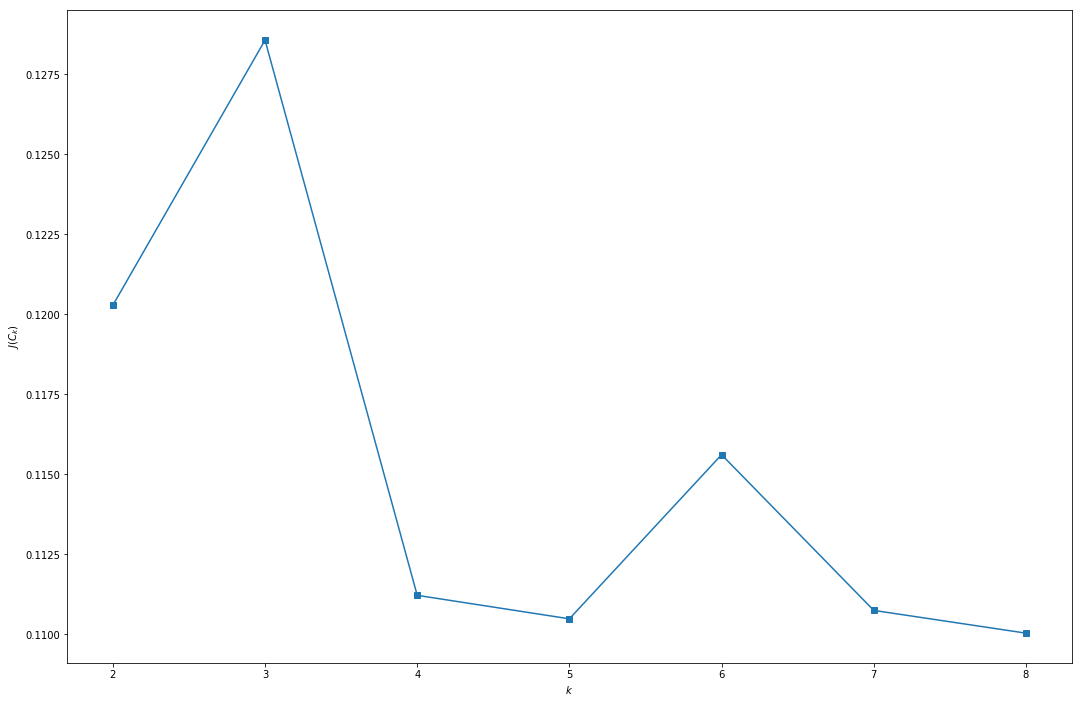

In [131]:
%%time
now = datetime.datetime.now()
print(now)
X1 = pd.DataFrame(X).sample(100000)

# с процентами новых и ОСН
from sklearn.metrics import silhouette_score
mas = []
mas1 = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X1)
    labels = kmeans.predict(X1)
    a1= silhouette_samples_memory_saving(X1, kmeans.labels_)
    #a= silhouette_score(X1, kmeans.labels_)
    #mas.append(a)
    mas1.append(a1)
    print(a1)

plt.plot(range(2, 9), mas1, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
# Оптимальное количество кластеров, для 99 % 3 кластера

In [101]:
%%time
now = datetime.datetime.now()
print(now)
X1 = pd.DataFrame(X).sample(50000)

# с процентами новых и ОСН
from sklearn.metrics import silhouette_score
mas = []
mas1 = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X1)
    labels = kmeans.predict(X1)
    #a1= silhouette_samples_memory_saving(X1, kmeans.labels_)
    #a= silhouette_score(X1, kmeans.labels_)
    mas.append(a)
    #mas1.append(a1)
    print(a)

plt.plot(range(2, 11), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
# Оптимальное количество кластеров, для 99 % 

2018-09-12 18:43:53.418536
0.033074344427156954
0.008235913235134595
0.008909030961310934


KeyboardInterrupt: 

Wall time: 42.5 s


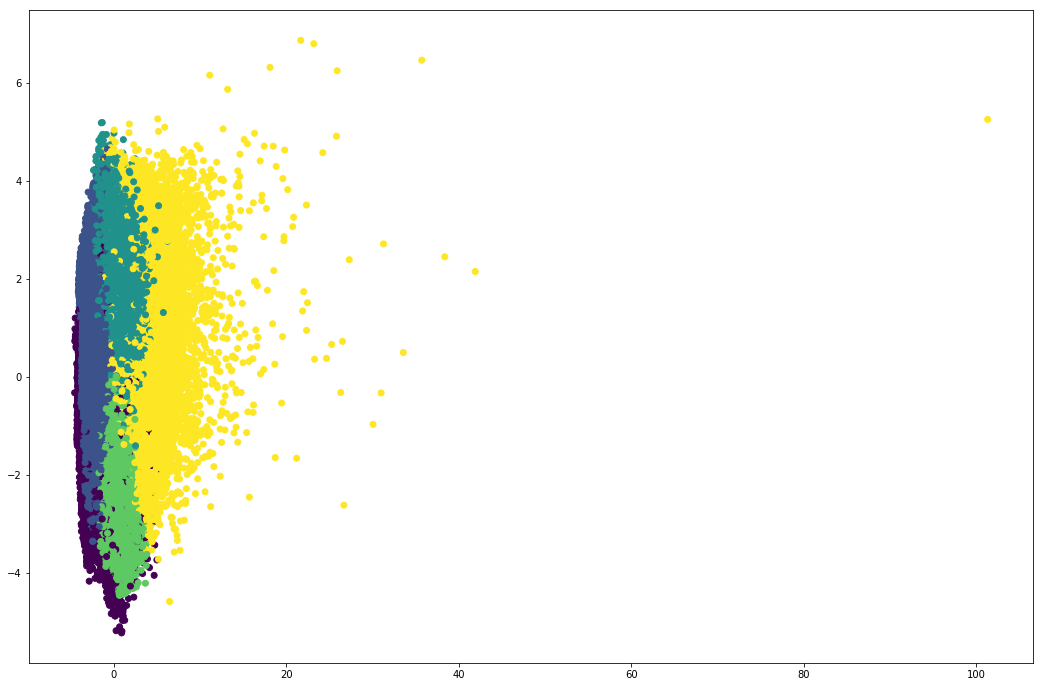

In [121]:
%%time
kmeans = KMeans(n_clusters= 5, random_state=1,n_jobs=-1).fit(X)
labels = kmeans.predict(X)
df['labels']=pd.DataFrame(labels)

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

In [122]:
df.head()

,PartnerID,Age,SEX,CityID,AvgDneyPrihodov,LifeTimeM,QntPurchaseCode,SumQuantity,SUMisPartnerPromotionID,PercentisPartnerPromotionID,...,SumGiftCardPositionID,AVGQntName,PercentExpensive,PercentCheap,PercentPremium,PercentMidle,PercentGold,PercentSilver,PercentNoMetal,labels
0,4,118,0,92,75,21,8,12.0,0,0,...,0,1,0.25,0.500000,0.0,0.250000,0.000000,0.916667,0.0,1
1,12,42,0,29,135,49,4,5.0,0,0,...,0,1,0.00,0.600000,0.0,0.400000,0.800000,0.000000,0.0,2
2,15,116,0,92,30,32,2,2.0,0,0,...,0,1,0.00,1.000000,0.0,0.000000,0.500000,0.500000,0.0,1
3,20,117,0,91,190,32,3,4.0,0,0,...,0,1,0.00,1.000000,0.0,0.000000,1.000000,0.000000,0.0,2
4,21,23,1,123,30,32,2,3.0,0,0,...,0,1,0.00,0.333333,0.0,0.666667,0.333333,0.333333,0.0,3


In [123]:
df.tail()

,PartnerID,Age,SEX,CityID,AvgDneyPrihodov,LifeTimeM,QntPurchaseCode,SumQuantity,SUMisPartnerPromotionID,PercentisPartnerPromotionID,...,SumGiftCardPositionID,AVGQntName,PercentExpensive,PercentCheap,PercentPremium,PercentMidle,PercentGold,PercentSilver,PercentNoMetal,labels
936304,6518477,35,1,112,0,0,2,2.0,0,0,...,0,1,0.5,0.0,0.0,0.5,1.0,0.0,0.0,3
936305,6518567,26,1,79,0,0,2,2.0,0,0,...,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
936306,6518898,50,0,101,0,0,2,2.0,0,0,...,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
936307,6518912,32,1,98,0,0,2,2.0,0,0,...,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3
936308,6521082,46,0,75,180,12,2,2.0,0,0,...,0,1,0.0,0.5,0.0,0.0,1.0,0.0,0.0,3


In [124]:
print(df.shape[0])
print(df[df['labels']==0].shape[0])
print(df[df['labels']==1].shape[0])
print(df[df['labels']==2].shape[0])
print(df[df['labels']==3].shape[0])
print(df[df['labels']==4].shape[0])
#print(df[df['labels']==5].shape[0])
#print(df[df['labels']==6].shape[0])

936309
35592
295251
158463
345247
101756


In [128]:
pd.concat([df[df['labels']==0].describe().T['50%'],df[df['labels']==0].describe().T['mean'],df[df['labels']==0].describe().T['std'], \
           df[df['labels']==1].describe().T['50%'],df[df['labels']==1].describe().T['mean'],df[df['labels']==1].describe().T['std'], \
           df[df['labels']==2].describe().T['50%'],df[df['labels']==2].describe().T['mean'],df[df['labels']==2].describe().T['std'], \
           df[df['labels']==3].describe().T['50%'],df[df['labels']==3].describe().T['mean'],df[df['labels']==3].describe().T['std'], \
           df[df['labels']==4].describe().T['50%'],df[df['labels']==4].describe().T['mean'],df[df['labels']==4].describe().T['std'], \
 #          df[df['labels']==5].describe().T['50%'],df[df['labels']==5].describe().T['mean'],df[df['labels']==5].describe().T['std'], \
 #          df[df['labels']==6].describe().T['50%'],df[df['labels']==6].describe().T['mean'],df[df['labels']==6].describe().T['std'], \
 #          df[df['labels']==7].describe().T['50%'],df[df['labels']==7].describe().T['mean'],df[df['labels']==7].describe().T['std'], \
 #          df[df['labels']==8].describe().T['50%'],df[df['labels']==8].describe().T['mean'],df[df['labels']==8].describe().T['std'], \
 #          df[df['labels']==9].describe().T['50%'],df[df['labels']==9].describe().T['mean'],df[df['labels']==9].describe().T['std'], \
           ],axis=1).to_csv('Client-last-Purch AVG-from 2015-more2Purch-99.csv')

In [129]:
2+2

4

In [20]:
df[df['labels']==4]

,PurchaseCode,PartnerID,Sex,Age,QntPurchaseCode,SUMisPartnerPromotionID,SUMisCrossPromo,SUMSMS30,SUMSMS14,SumQuantity,...,AVGIsMidle,SumIsUnknownLevel,AVGIsUnknownLevel,SumIsGold,AVGIsGold,SumIsSilver,AVGIsSilver,SumIsNoMetal,AVGIsNoMetal,labels
982396,1202847493,2377429,0.0,0,409,0,0,399,399,9.0,...,5,0,0,3415,8,2414,5,1,0,4
1022005,1198824994,5319346,0.0,67,542,542,0,445,444,4.0,...,4,0,0,2901,5,2723,5,0,0,4
1114227,1201040800,5283999,1.0,51,294,281,0,274,265,32.0,...,4,0,0,1354,4,1397,4,306,1,4
1292769,1212129462,1494590,0.0,36,131,66,22,48,45,16.0,...,18,0,0,2411,18,2514,19,48,0,4
1499811,1217186965,5339367,1.0,37,117,114,0,116,103,1.0,...,14,0,0,2456,20,1561,13,167,1,4
